Are value neurons in fact time neurons / goal progress neuron?

use time lapse / goal progress within each trial is a regressor

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import pynwb
import h5py
from tqdm import tqdm
from pathlib import Path 
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.signal import resample, find_peaks

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
import seaborn as sns

import graph
import load_data
import LFP
import single_neuron_vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class ThetaDataset:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.phase = self.f['phase']

    def get_trace(self, time):
        return self.band_sig[time, :].T, self.power[time, :].T, self.phase[time, :].T

    def get_band_sig(self, time):
        if len(time)==0:
            return self.band_sig[:]
        else:
            return self.band_sig[time, :]

    def get_power(self, time):
        if len(time)==0:
            return self.power[:]
        else:
            return self.power[time, :]

    def get_phase(self, time):
        if len(time)==0:
            return self.phase[:]
        else:
            return self.phase[time, :]

    def close(self):
        self.f.close()

In [3]:
sz1 = 16
sz2 = 18
sz3 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz3) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [4]:
def plot_sem(time, trace, ax, ii, label):

    colors = sns.color_palette('Set1',3)
    mean_trace = trace.mean(axis=0)
    sem_trace = trace.std(axis=0)/np.sqrt(trace.shape[0])
    ax.plot(time, mean_trace, color=colors[ii], label=label)
    ax.fill_between(time,
                    mean_trace - sem_trace,
                    mean_trace + sem_trace,
                    color=colors[ii],
                    alpha=0.3)

In [5]:
# load tuning of individual neuron characterized with regression model
tuning = pd.read_pickle("D:/SingleNeuron/Tuning all steps.pkl")

# get session-level params
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London
neural_timeseries_index = 0
region = 'HPC'

In [10]:
HPC_tuning = tuning.query('value & (region==@region)')

In [12]:
for ii in [0]:#range(1,8): #range(len(all_sessions)):

    date = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, date)

    # get spatial neurons from a given session
    session_tuning = tuning.query('(Session==@date)&(region==@region)').copy()
    if np.all(np.isnan(session_tuning['unitNumber'].values)):
        session_tuning['unitNumber']=session_tuning['cluster_id']
    
    value_neuron = session_tuning.query('value')
    
    # load in spikes aligned to a given epoch
    query = 'trialerror==0'
    spike_table = load_data.load_beh_neural(animal, date, region, 'action_on', query)


Bart 031723
Building Spike Table


1499it [00:00, 3951.68it/s]


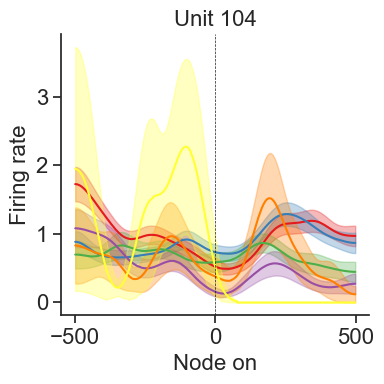

In [14]:
# for neuronID in goal_neuron.unitNumber.values.astype(int):
neuronID = 104
plt.close('all')
ax = single_neuron_vis.plot_sdf(spike_table, neuronID,'graph_distance', sns.color_palette('Set1',16), ax=None)
ax.set_title(f'Unit {neuronID}')
ax.set_xlabel('Node on')
plt.tight_layout()
# plt.savefig(f'D:/Goal/Session {date}, Unit {neuronID}, Flash trial, goal')

In [6]:
def extract_trial_time(choice_df, fix_df, trial_df, node, neural_timeseries_index=0):
    
    trials = choice_df.query("(node==@node)&(trialerror==0)").trial.values
    n_trials = len(trials)

    fix_node_time = np.full((n_trials, 500), np.nan)
    next_node = np.zeros(n_trials)
    n_ts = np.zeros(n_trials)

    trial_meta = []   # store per-trial info needed later

    for ii, trial in enumerate(trials):

        curr_node = choice_df.query('(trial==@trial)&(node==@node)')
        curr_node_on = curr_node.t_on.values[0]
        next_step = curr_node.step.values[0] + 1

        next_df = choice_df.query('(trial==@trial)&(step==@next_step)')
        next_action_on = next_df.t_on.values[0]
        next_node[ii] = next_df.node.values[0]

        # --- fixation window ---
        temp1 = fix_df.start_time.values < (next_action_on - 500)
        fix_idx1 = int(np.argmin(temp1.astype(int))) - 1

        temp2 = fix_df.stop_time.values > next_action_on
        fix_idx2 = int(np.argmin((~temp2).astype(int)))

        fixations_per_choice = fix_df.iloc[fix_idx1:fix_idx2]

        for _, row in fixations_per_choice.iterrows():
            t_min = int(max(next_action_on - 500, row.start_time) - next_action_on + 500)
            t_max = int(min(next_action_on, row.stop_time) - next_action_on + 500)
            fix_node_time[ii, t_min:t_max] = row.fix_node

        # --- timestamps shared across neurons ---
        trial_ts = trial_df.query("trial==@trial").iloc[0] \
                           .timeseries[neural_timeseries_index].timestamps

        time_idx = (trial_ts >= curr_node_on - 500) & \
                   (trial_ts < next_action_on + 1000)

        n_ts[ii] = np.sum(time_idx)

        trial_meta.append(dict(
            trial=trial,
            curr_node_on=curr_node_on,
            next_action_on=next_action_on,
            time_idx=time_idx
        ))

    return trials, trial_meta, fix_node_time, next_node


In [21]:
def hypothesis1(choice_df, tele_df, trial_df, fix_df, node, unit_idx, date):

    trials, trial_meta, fix_node_time, next_node = \
        extract_trial_time(choice_df, fix_df, trial_df, node)

    n_trials = len(trials)

    for neuron_idx in tele_df.index.astype(int):

        warped = np.zeros((n_trials, 2100))
        aligned = np.zeros((2, n_trials, 1000))

        unitNumber = int(tele_df.loc[neuron_idx].unitNumber)

        for ii, meta in enumerate(trial_meta):

            trial = int(meta['trial'])
            ts = trial_df.query("trial==@trial").iloc[0] \
                         .timeseries[neural_timeseries_index]

            trial_spikes = ts.data[:, unit_idx]
            spikes = trial_spikes[meta['time_idx'], neuron_idx]

            sdf = single_neuron_vis.get_sdf(spikes.astype(int), sigma=25)

            warped[ii, :500] = sdf[:500]
            warped[ii, -1000:] = sdf[-1000:]
            warped[ii, 500:-1000] = resample(sdf[500:-1000], 600)

            aligned[0, ii, :] = sdf[:1000]
            aligned[1, ii, :] = sdf[-1500:-500]

        plot_tele_sdf(date, unitNumber, np.arange(-500, 500), aligned, node, next_node, fix_node_time)


In [ ]:
# plot node tuning
for neuronID in teleporter.unitNumber.values.astype(int):
    plt.close('all')
    ax = single_neuron_vis.plot_sdf(spike_table, neuronID,'node', sns.color_palette('Set1',16), ax=None)
    ax.set_title(f'Unit {neuronID}')
    plt.savefig(f'D:/SingleNeuron/Session {date}, Unit {neuronID}, Teleporter')

In [32]:
def plot_tele_sdf(session, unitNumber, time, aligned, curr_node, next_node, fix_node_time):
    
    # Hypothesis 1, figures
    # plot aligned sdf and fixation probability
    plt.close('all')
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    time = np.arange(-500,500)
    
    for ii, node in enumerate(np.unique(next_node)):
        
        idx = next_node==node
        plot_sem(time, aligned[0,idx,:], axes[0], ii, f'{node}')
        plot_sem(time, aligned[1,idx,:], axes[1], ii, f'{node}')
        
        axes[0].axvline(0,color='k',ls='--')
        axes[1].axvline(0,color='k',ls='--')
    
    axes[2].plot(np.arange(-500,0),np.nanmean(fix_node_time[next_node==15-curr_node,:]==15-curr_node,axis=0))
    axes[2].set_title(f'Fixation on node {15-curr_node}\nNode(t+1) -500ms to 0ms')
    
    axes[1].legend()
    axes[0].set_title(f'Node(t)={curr_node}')
    axes[1].set_title('Node(t+1)')
    axes[0].set_xlabel('Action on(ms)')
    axes[1].set_xlabel('Action on(ms)')

    ymins = []
    ymaxs = []
    for ax in (axes[0], axes[1]):
        ymin, ymax = ax.dataLim.intervaly
        ymins.append(ymin)
        ymaxs.append(ymax)
    axes[0].set_ylim(min(ymins), max(ymaxs))
    axes[1].set_ylim(min(ymins), max(ymaxs))

    plt.tight_layout()

    plt.suptitle(f'Teleport neuron session {session}, HPC unit {unitNumber}')
        
    plt.savefig(f'D:/Teleporter/Teleport neuron session {session}, HPC unit {unitNumber}')

In [104]:
# Hypothesis 2
# find node 15, its previous step and next step, visualize theta and spikes from trial to trial, along with fixations
# look separately at node 0

trials = choice_df.query("(node==15)&(trialerror==0)").trial.values

alltrial = []
alltrial_fix = []

for ii, trial in enumerate(trials):

    curr_action = choice_df.query('(trial==@trial)&(node==15)')
    curr_action_on = curr_action.t_on.values[0]
    
    if curr_action.step.values[0]>0:
        pre_step = curr_action.step.values[0]-1
        pre_df = choice_df.query('(trial==@trial)&(step==@pre_step)')
        pre_action_on = pre_df.t_on.values[0]
    else:
        pre_action_on = curr_action_on
    
    next_step = curr_action.step.values[0]+1
    next_df = choice_df.query('(trial==@trial)&(step==@next_step)')
    next_action_on = next_df.t_on.values[0]

    # define the time window to look at lfp, spikes, and fixation node
    trial_window = np.arange(pre_action_on - 500, next_action_on + 500)

    # get spikes
    trial_timeseries = trial_df.query("trial==@trial").iloc[0].timeseries[neural_timeseries_index]
    trial_ts = trial_timeseries.timestamps
    trial_spikes = trial_timeseries.data[:,unit_idx]
    time_idx = (trial_ts >= trial_window[0]) & (trial_ts < trial_window[-1])
    cell_trial_spikes = 1*((trial_spikes[:,31]+trial_spikes[:,34])>0)[time_idx]
    sdf = single_neuron_vis.get_sdf(cell_trial_spikes,sigma=25)

    # get lfp
    idx = (timestamps >= trial_window[0]) & (timestamps < trial_window[-1])
    analytic, power, phase = ds.get_trace(idx)
    channel = int(unitNames.channelNumbers.iloc[31])-1
    phase_unwrapped = np.unwrap(phase[channel,:])
    curr_action_on_phase = phase_unwrapped[trial_window[:-1]==curr_action_on]

    # get fixations information
    
    temp = fix_df.start_time.values < trial_window[0]
    fix_idx1 = int(np.argmin(temp*1))-1
    
    temp = fix_df.stop_time.values > trial_window[-1]
    fix_idx2 = int(np.argmin(1-temp*1))
    
    fixations_per_choice = fix_df.iloc[fix_idx1:fix_idx2]
    fix_node = np.zeros(len(trial_window)-1)*np.nan
    fix_info = np.zeros((len(fixations_per_choice),3))
    
    for ff, row in enumerate(fixations_per_choice.itertuples(index=False)):
    
        t_min = int(np.max([trial_window[0],row.start_time])-trial_window[0])
        t_max = int(np.min([trial_window[-1],row.stop_time])-trial_window[0])
    
        fix_node[t_min:t_max] = row.fix_node
        fix_info[ff,0] = row.start_time - curr_action_on
        fix_info[ff,1] = row.stop_time - curr_action_on
        fix_info[ff,2] = row.fix_node
    

    alltrial.append(np.array([trial_window[:-1]-curr_action_on,
                             cell_trial_spikes,
                             analytic[channel,:],
                              phase[channel,:],
                              phase_unwrapped-curr_action_on_phase,
                             fix_node]))
    alltrial_fix.append(fix_info)


In [139]:
# phase precession may be manifested in progress of nodes or simply in the progress of time
# time is theta-cycle normalized 

In [ ]:
# align theta-cycle normalized time to current action onset

In [211]:
def cycle_normalized_time(this_trial):
    
    """
    spike_idx   : spike times in samples
    trough_idx  : theta trough indices (samples)
    
    Returns:
        tau        : normalized time within cycle [0,1]
        cycle_idx  : theta cycle index for each spike
    """
    
    # find theta troughs
    trough_idx,_ = find_peaks(-this_trial[3,:],distance=100)
    
    # get spikes indices
    spike_idx = np.where(this_trial[1,:])[0]
    
    # assign each spike to a cycle
    cycle_idx = np.searchsorted(trough_idx, spike_idx, side='right') 
    
    valid = (cycle_idx >= 0) & (cycle_idx < len(trough_idx)-1)
    spike_idx = spike_idx[valid]
    cycle_idx = cycle_idx[valid]
    
    t0 = trough_idx[cycle_idx]
    t1 = trough_idx[cycle_idx + 1]
    
    tau = (spike_idx - t0) / (t1 - t0) + cycle_idx

    
    time0_idx = np.where(this_trial[0,:]==0)[0][0]
    time0_cycle_idx = np.searchsorted(trough_idx, time0_idx, side='right') 
    time0 = (time0_idx - trough_idx[time0_cycle_idx]) / (trough_idx[time0_cycle_idx+1] - trough_idx[time0_cycle_idx]) + time0_cycle_idx
    
    return tau-time0, cycle_idx, spike_idx


In [226]:
from pycircstat2.correlation import circ_corrcl
results = circ_corrcl(np.hstack(all_phase), np.hstack(all_tau))

TypeError: cannot unpack non-iterable CorrelationResult object

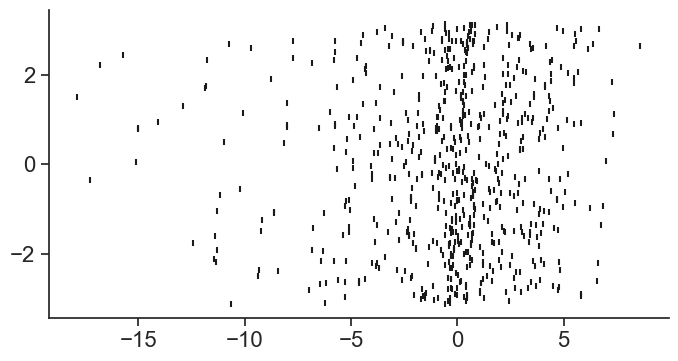

In [218]:
all_tau = []
all_phase = []

plt.close('all')
fig, axes = plt.subplots(figsize=(8,4))
for ii in range(20):
    this_trial = alltrial[ii]
    tau, cycle_idx, spike_idx = cycle_normalized_time(this_trial)
    axes.scatter(tau,this_trial[3,spike_idx], marker = "|", c="k", s=20)
    
    all_tau.append(tau[(tau>-5)&(tau<5)])
    all_phase.append(this_trial[3,spike_idx[(tau>-5)&(tau<5)]])
    

(-2000.0, 2000.0)

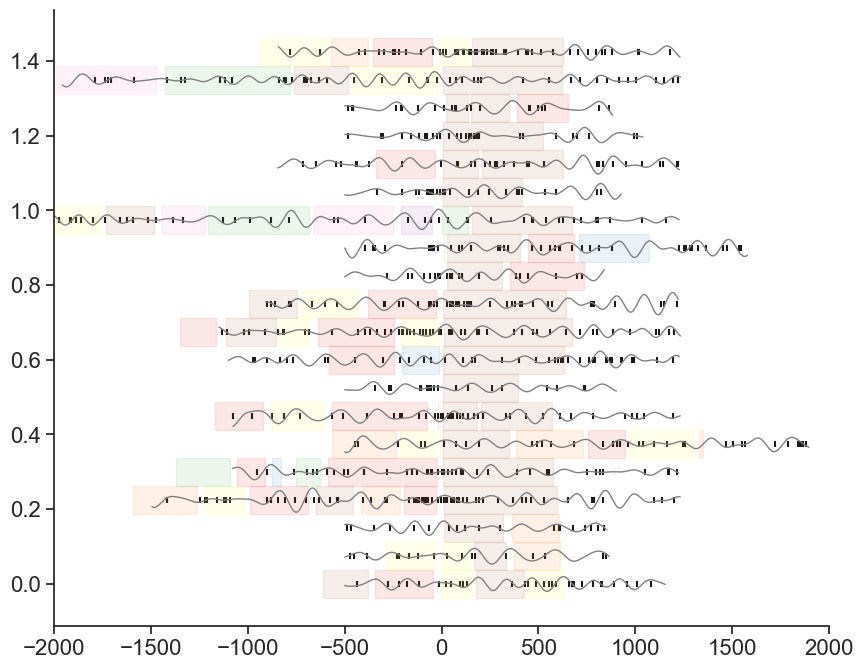

In [94]:
# time, spikes, lfp, fixation node

colors = sns.color_palette('Set1',16)

plt.close('all')
fig, axes = plt.subplots(figsize=(10,8))
scale = 0.075

for ii in range(20):
    
    X, Y = np.where(alltrial[ii][1,:].reshape(1,-1))
    axes.plot(alltrial[ii][0,:],alltrial[ii][2,:]+ii*scale,color='grey',lw=1)
    axes.scatter(Y+alltrial[ii][0,0], X+ii*scale, marker = "|", c="k", s=20)

    for ff in range(len(alltrial_fix[ii])):
        axes.fill_betweenx([ii*scale-scale/2, ii*scale+scale/2],alltrial_fix[ii][ff,0],alltrial_fix[ii][ff,1],
                           color = colors[int(alltrial_fix[ii][ff,2])],alpha=0.1)


plt.xlim(-2000,2000)

In [ ]:
look at theta power, when it is above 3sd, whether there is a pattern

In [ ]:
# get data aligned to node 0 and then node 15 in a trial, choice fixations

colors = sns.color_palette('Set1',16)

nodes = [0,15]

tele_trials = choice_df.query("(use_tele) & (target==14)").copy()
trial_idx = tele_trials.trial.unique()
ts = np.arange(-500,1500)
sample_data = np.zeros((2,len(trial_idx),2000))*np.nan
start_times_all = np.zeros((2,len(trial_idx)))

for ii, tt in enumerate(trial_idx):
    
    trial_timeseries = trial_df.query("trial==@tt").iloc[0].timeseries[neural_timeseries_index]
    trial_ts = trial_timeseries.timestamps
    trial_spikes = trial_timeseries.data[:,unit_idx]
    cell_trial_spikes = (trial_spikes[:,31]+trial_spikes[:,34])>0
    
    choices_per_trial = choice_df.query("trial==@tt")
    choice_idx = np.where((choices_per_trial.node==nodes[1])&(choices_per_trial.prenode==nodes[0]))[0][0]
    choices_per_trial = choices_per_trial.iloc[choice_idx-1:choice_idx+1,:]
    start_times = choices_per_trial.t_on.values
    start_times_all[:,ii] = start_times
    
    for jj in range(2):
        
        time_idx = (trial_ts >= start_times[jj] - 500) & (trial_ts < start_times[jj] + 1500)
        sample_data[jj,ii,:] = cell_trial_spikes[time_idx]


# sort spikes by node, choice fixations

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(8,5),facecolor=(1, 1, 1))

for jj in range(2):
    # plot spike raster
    X, Y = np.where(sample_data[jj])
    axs[jj].scatter(Y-500, X+45, marker = "|", c="k", s=20)
    axs[jj].plot(np.arange(-500,1500),movmean(sample_data[jj].mean(axis=0)*1000, w=75).flatten(),'k-')
    sns.despine()
    
    
    for ii, tt in enumerate(trial_idx):
    
        fix_idx = ((fix_df.start_time >= start_times_all[jj,ii] - 500) & (fix_df.start_time < start_times_all[jj,ii] + 1500)) | \
                    ((fix_df.stop_time >= start_times_all[jj,ii] - 500) & (fix_df.stop_time < start_times_all[jj,ii] + 1500)) 
        fixations_per_choice = fix_df[fix_idx]
    
        fixation_starts = fixations_per_choice.start_time.values - start_times_all[jj,ii] 
        fixation_stops = fixations_per_choice.stop_time.values - start_times_all[jj,ii] 
        fixation_nodes = fixations_per_choice.fix_node.values
        
        for ff in range(len(fixations_per_choice)):
            axs[jj].fill_betweenx([ii+45-0.5, ii+45+0.5],fixation_starts[ff],fixation_stops[ff],color = colors[fixation_nodes[ff]],alpha=0.01)
    
    axs[jj].set_xlim(-500,1500)
    axs[jj].set_xlabel('Action on, Node '+str(nodes[jj]))
    
    if jj==1:
        axs[jj].set_yticks([])
        axs[jj].spines[['left','right', 'top']].set_visible(False)
    else:
        axs[jj].set_ylabel('Trial number')

    axs[jj].plot([0,0],[0,90],'k--')
    axs[jj].set_ylim(5,90)
    

for cc in [0,14,15]:
    axs[jj].fill_betweenx([0, 0],0,0,color = colors[cc],alpha=0.1,label='Node '+str(cc))
    
plt.legend(loc=(0.45,0.25),frameon=False)
plt.suptitle('Teleport: 0 -> 15')
plt.savefig('HPC Unit 88 teleport 0 to 15.jpg')